# Detecting spouse mentions in sentences

#### Disclaimer: this notebook use several Snorkel tutorials

In this tutorial, we will see how Snorkel can be used for Information Extraction. We will walk through an example text classification task for information extraction, where we use labeling functions involving keywords and distant supervision.
### Classification Task
<img src="https://github.com/snorkel-team/snorkel-tutorials/blob/master/spouse/imgs/sentence.jpg?raw=1" width="700px;" onerror="this.onerror=null; this.src='/doks-theme/assets/images/sentence.jpg';" align="center" style="display: block; margin-left: auto; margin-right: auto;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


### Seminar (3 points)

In [ ]:
%matplotlib inline

import os
import pandas as pd
import pickle
import subprocess
from typing import Tuple

import numpy as np
import pandas as pd


In [ ]:
!wget https://www.dropbox.com/s/jmrvyaqew4zp9cy/spouse_data.zip -O data.zip
!unzip data.zip
!rm data.zip
!rm trained_spouse_model

In [ ]:
def load_data() -> Tuple[
    Tuple[pd.DataFrame, np.ndarray], pd.DataFrame, Tuple[pd.DataFrame, np.ndarray]
]:
    """
    Returns:
        df_dev, Y_dev: Development set data points and 1D labels ndarray.
        df_train: Training set data points dataframe.
        df_test, Y_test: Test set data points dataframe and 1D labels ndarray.
    """
    with open("dev_data.pkl", "rb") as f:
        df_dev = pickle.load(f)
        Y_dev = pickle.load(f)

    with open("train_data.pkl", "rb") as f:
        df_train = pickle.load(f)

    with open("test_data.pkl", "rb") as f:
        df_test = pickle.load(f)
        Y_test = pickle.load(f)

    # Convert labels to {0, 1} format from {-1, 1} format.
    Y_dev = (1 + Y_dev) // 2
    Y_test = (1 + Y_test) // 2
    return ((df_dev, Y_dev), df_train, (df_test, Y_test))

In [ ]:
((df_dev, Y_dev), df_train, (df_test, Y_test)) = load_data()

**Input Data:** `df_dev`, `df_train`, and `df_test` are `Pandas DataFrame` objects, where each row represents a particular __candidate__. For our problem, a candidate consists of a sentence, and two people mentioned in the sentence. The DataFrames contain the fields `sentence`, which refers to the sentence of the candidate, `tokens`, the tokenized form of the sentence, and `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below.

In [ ]:
# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", 0)

df_dev.head()

In [ ]:
!pip3 install snorkel

### Preprocessing the Data

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we generate candidates and dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

### Labeling Function Helpers

When writing labeling functions, there are several functions you will use over and over again. In the case of text relation extraction as with this task, common functions include those for fetching text between mentions of the two people in a candidate, examing word windows around person mentions, and so on.

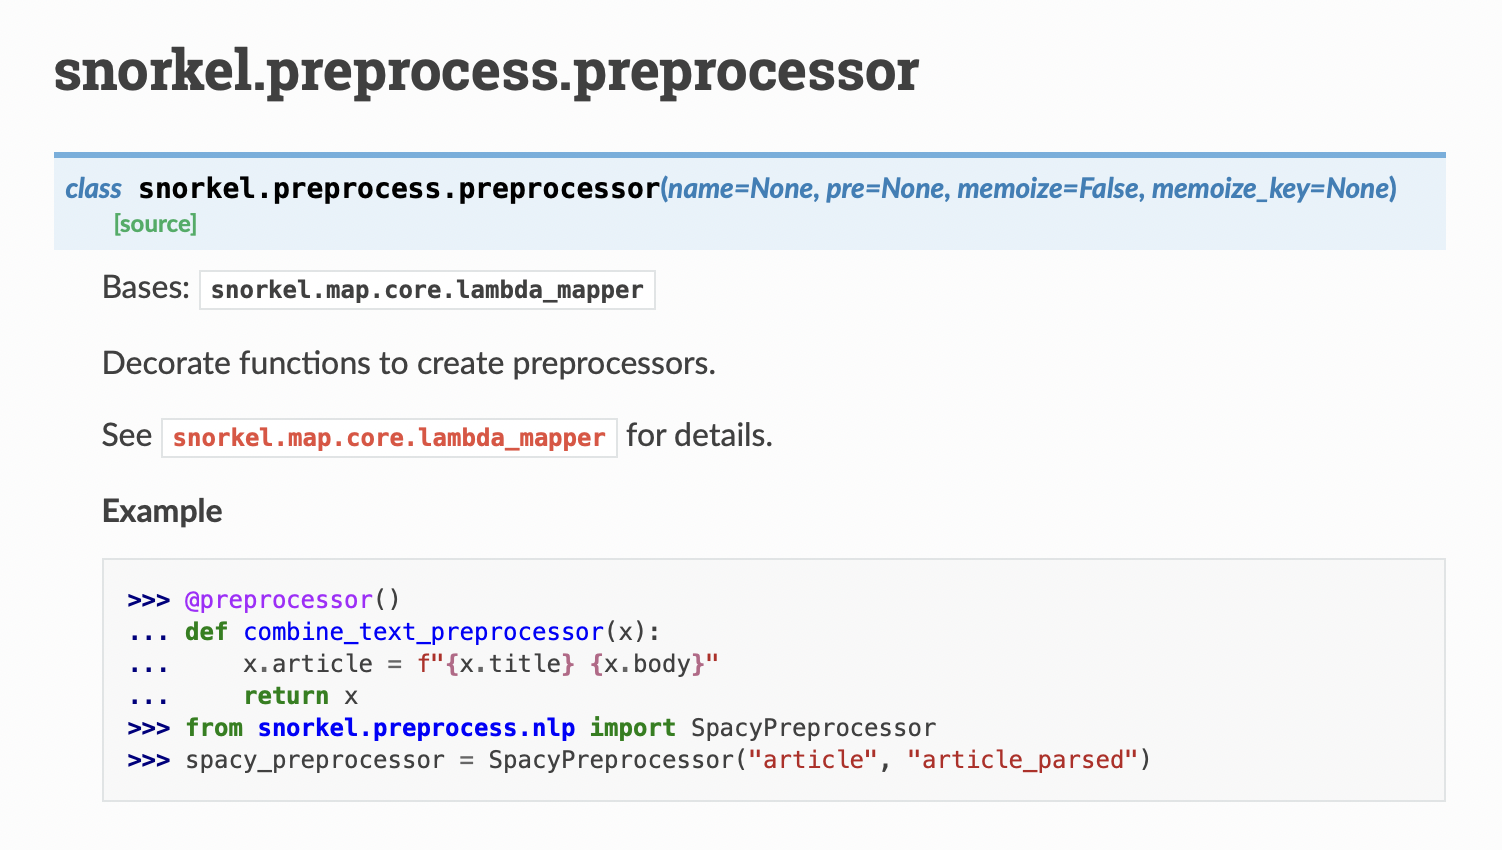

In [ ]:
# +
from typing import Optional

from snorkel.preprocess import preprocessor
from snorkel.types import DataPoint

@preprocessor()
def get_person_text(cand: DataPoint) -> DataPoint:
    """
    Returns the text for the two person mentions in candidate
    """
    # YOUR CODE IS HERE


In [ ]:
# Let's look at a candidate in the development set:

candidate = df_dev.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

### Candidate PreProcessors

For the purposes of the tutorial, we have three fields (`between_tokens`, `person1_right_tokens`, `person2_right_tokens`) preprocessed in the data, which can be used when creating labeling functions. We also provide the following set of `preprocessor`s for this task in `preprocessors.py`, along with the fields these populate.
* `get_person_text(cand)`: `person_names`
* `get_person_lastnames(cand)`: `person_lastnames`
* `get_left_tokens(cand)`: `person1_left_tokens`, `person2_left_tokens`

In [ ]:
@preprocessor()
def get_text_between(cand: DataPoint) -> DataPoint:
    """
    Returns the text between the two person mentions in the sentence
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

@preprocessor()
def get_person_last_names(cand: DataPoint) -> DataPoint:
    """
    Returns the last names for the two person mentions in candidate
    """
    cand = get_person_text(cand)
    person1_name, person2_name = cand.person_names
    person1_lastname = (
        person1_name.split(" ")[-1] if len(person1_name.split(" ")) > 1 else None
    )
    person2_lastname = (
        person2_name.split(" ")[-1] if len(person2_name.split(" ")) > 1 else None
    )
    cand.person_lastnames = [person1_lastname, person2_lastname]
    return cand


@preprocessor()
def get_left_tokens(cand: DataPoint) -> DataPoint:
    """
    Returns tokens in the length 3 window to the left of the person mentions
    """
    # TODO: need to pass window as input params
    window = 3

    end = cand.person1_word_idx[0]
    cand.person1_left_tokens = cand.tokens[0:end][-1 - window : -1]

    end = cand.person2_word_idx[0]
    cand.person2_left_tokens = cand.tokens[0:end][-1 - window : -1]
    return cand


# Helper function to get last name for dbpedia entries.
def last_name(s: str) -> Optional[str]:
    name_parts = s.split(" ")
    return name_parts[-1] if len(name_parts) > 1 else None


In [ ]:
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [ ]:
from snorkel.labeling import labeling_function

# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    # YOUR CODE IS HERE

In [ ]:
for row in df_dev.sample(n=30).iterrows():
  print("---")
  print(row[1].sentence)
  print(get_person_text(row[1]).person_names)
  print(lf_husband_wife(row[1]))

In [ ]:
candidate.sentence

In [ ]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), pre=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    # YOUR CODE IS HERE

In [ ]:
# Check for the person mentions having the same last name
@labeling_function(pre=[get_person_last_names])
def lf_same_last_name(x):
    # YOUR CODE IS HERE

In [ ]:
# Check for the word `married` between person mentions
@labeling_function()
def lf_married(x):
    return POSITIVE if "married" in x.between_tokens else ABSTAIN

In [ ]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = {
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
}
family = family.union({f + "-in-law" for f in family})


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), pre=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [ ]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    # YOUR CODE IS HERE

### Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ data points. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

[**DBpedia**](http://wiki.dbpedia.org/): Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [ ]:
with open("dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

In [ ]:
@labeling_function(resources=dict(known_spouses=known_spouses), pre=[get_person_text])
def lf_distant_supervision(x, known_spouses):
    # YOUR CODE IS HERE

In [ ]:
# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(resources=dict(last_names=last_names), pre=[get_person_last_names])
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [ ]:
from snorkel.labeling import PandasLFApplier

lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [ ]:
from snorkel.labeling import LFAnalysis

L_dev = applier.apply(df_dev)
L_train = applier.apply(df_train)

In [ ]:
LFAnalysis(L_dev, lfs).lf_summary(Y_dev)

### Training the Label Model

Now, we'll train a model of the LFs to estimate their weights and combine their outputs. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor.

In [ ]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, Y_dev, n_epochs=5000, log_freq=500, seed=12345)

### Label Model Metrics
Since our dataset is highly unbalanced (91% of the labels are negative), even a trivial baseline that always outputs negative can get a high accuracy. So we evaluate the label model using the F1 score and ROC-AUC rather than accuracy.

In [ ]:
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds

probs_dev = label_model.predict_proba(L_dev)
preds_dev = probs_to_preds(probs_dev)
print(
    f"Label model f1 score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')}"
)
print(
    f"Label model roc-auc: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')}"
)

## Homework(Training our End Extraction Model) - 3 points

In this final section of the tutorial, we'll use our noisy training labels to train our end machine learning model.
Your task is to make quite straightforward classification model. This model should predict whether a pair of names is a spouse group or not based on sentence embedding, and two name embeddings.


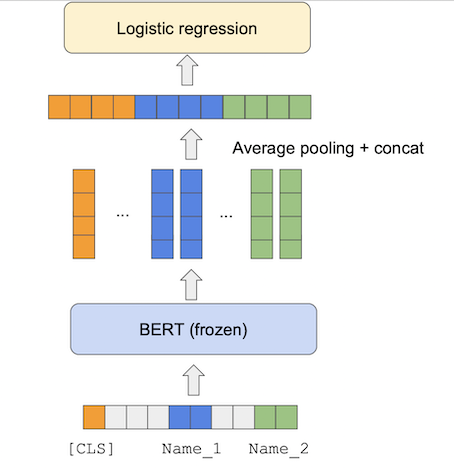

We start by filtering out training data points which did not recieve a label from any LF, as these data points contain no signal.

In [ ]:
from snorkel.labeling import filter_unlabeled_dataframe

probs_train = label_model.predict_proba(L_train)
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [ ]:
!pip3 install transformers

Finally, we evaluate the trained model by measuring its F1 score and ROC_AUC.

In [ ]:
X_test = #get_feature_arrays(df_test)
probs_test = model.predict(X_test)
preds_test = probs_to_preds(probs_test)
print(
    f"Test F1 when trained with soft labels: {metric_score(Y_test, preds=preds_test, metric='f1')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(Y_test, probs=probs_test, metric='roc_auc')}"
)